In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseCategoricalCrossentropy, Accuracy
from tensorflow.keras.losses import sparse_categorical_crossentropy
from models import *
from tqdm import tqdm


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])


In [4]:
contrastive_df = pd.read_csv('contrastive.csv')

In [5]:
import matplotlib.pyplot as plt
import PIL
plt.style.use('dark_background')

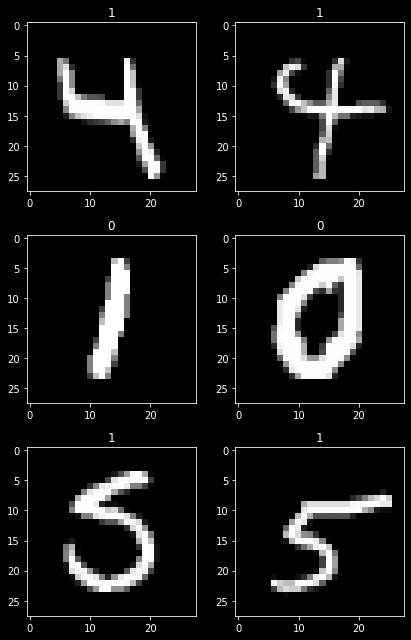

In [6]:
size = 3
samples = 3
fig, axes = plt.subplots(3, 2, figsize=(2*size, 3*size))
for n, (path1, path2, label) in enumerate(contrastive_df.sample(samples).values):  
    ax1, ax2 = axes[n]
    im1 = np.asarray(PIL.Image.open(path1))
    im2 = np.asarray(PIL.Image.open(path2))
    ax1.imshow(im1, cmap='binary')
    ax2.imshow(im2, cmap='binary')
    ax1.set_title(label)
    ax2.set_title(label)
    
plt.tight_layout()

In [7]:
class_cnn = tf.keras.models.load_model(
    "../models/class_model", custom_objects={"ClasSCNN": ClassCNN}
)

In [8]:
inputs = tf.random.normal((1,28,28,1))
_ = class_cnn(inputs)

In [9]:
class_cnn(np.expand_dims(im2, (0,3)).astype(float))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ -6.8520913 , -13.688127  , -13.878451  ,  -0.38683134,
         -6.8246193 ,  18.353195  ,  -0.7130484 , -14.899568  ,
         -1.4467903 ,  -1.3178328 ]], dtype=float32)>

In [10]:
class_cnn.trainable=False

In [11]:
optimizer = tf.keras.optimizers.Adam()

In [132]:
def give_image(number):
    image = tf.Variable(tf.random.uniform(shape=(1,28,28,1)))
    one_hot = np.zeros(10)
    one_hot[number] = 1
    one_hot = tf.constant(one_hot, dtype=float)
    
    def forward(image):
        x = tf.multiply(image, 255)
        x = tf.squeeze(class_cnn(x))
        return tf.tensordot(x, one_hot, axes=1)
    
    for n in tqdm(range(10000)):
        with tf.GradientTape() as tape:
            loss = forward(image)
        grad = tape.gradient(loss, image) 
        #print(grad)
    #     print(grad.shape)
    #     print(image.shape)
        optimizer.apply_gradients([(-grad, image)])

    return image.numpy()[0,:,:,0]


In [140]:
class CoolFigure:
    def __init__(self):
        for n in range(10):
            print(f'Generating image {n}')
            vars(self)[f'{n}_image'] = give_image(n)

In [141]:
cool_fig = CoolFigure()

  0%|          | 17/10000 [00:00<01:00, 163.74it/s]

Generating image 0


  0%|          | 17/10000 [00:00<00:59, 167.12it/s]

Generating image 1


  0%|          | 18/10000 [00:00<00:55, 178.95it/s]

Generating image 2


  0%|          | 19/10000 [00:00<00:54, 183.23it/s]

Generating image 3


  0%|          | 18/10000 [00:00<00:57, 174.18it/s]

Generating image 4


  0%|          | 15/10000 [00:00<01:06, 149.05it/s]

Generating image 5


  0%|          | 17/10000 [00:00<00:59, 167.35it/s]

Generating image 6


  0%|          | 18/10000 [00:00<00:58, 171.44it/s]

Generating image 7


  0%|          | 18/10000 [00:00<00:57, 174.99it/s]

Generating image 8


  0%|          | 17/10000 [00:00<00:59, 168.31it/s]

Generating image 9


100%|██████████| 10000/10000 [00:58<00:00, 170.84it/s]


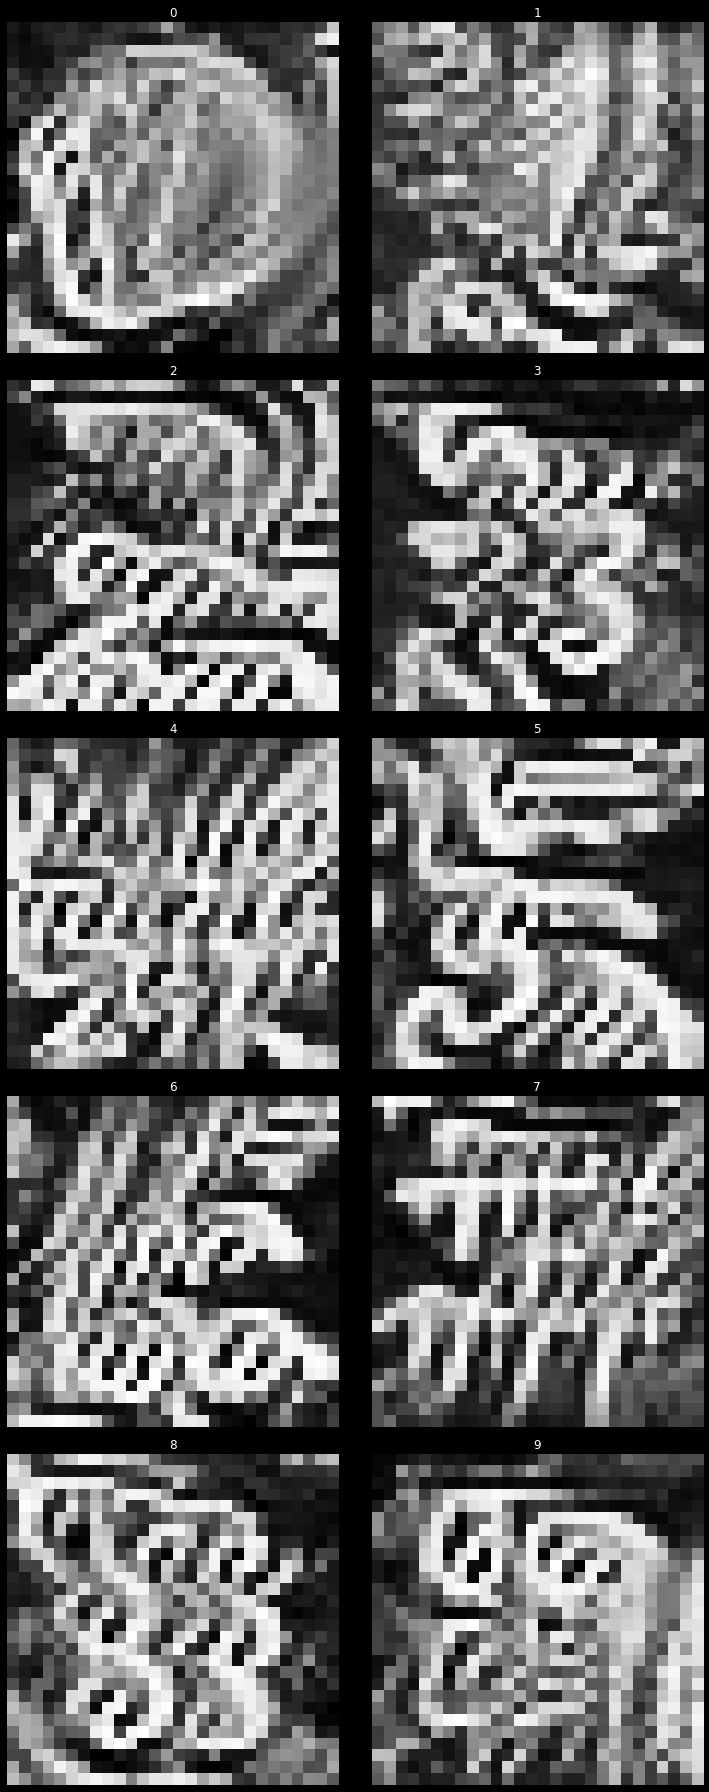

In [162]:
fig, axes = plt.subplots(5,2,figsize=(10,25))
for n in range(10):
    axis = axes.flatten()[n]
    img = vars(cool_fig)[f'{n}_image']
    
    axis.imshow(img, cmap='binary')
    axis.set_title(n)
    axis.axis('off')
    
plt.tight_layout(w_pad=5)